# Tutorial
## https://www.youtube.com/watch?v=fyZ9Rxpoz2I&ab_channel=DigitalSreeni


In [32]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image



In [33]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
LabelEncoder()
print(list(label_encoder.classes_))

df['label'] = label_encoder.transform(df["dx"])
print(df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id     dx    dx_type   age     sex  \
4169  HAM_0006860  ISIC_0032500     nv  follow_up  40.0    male   
1245  HAM_0001811  ISIC_0028069    mel      histo  35.0  female   
9759  HAM_0001173  ISIC_0030827  akiec      histo  40.0  female   
8999  HAM_0005537  ISIC_0028643     nv      histo  60.0    male   
4371  HAM_0003733  ISIC_0025448     nv  follow_up  40.0  female   
3912  HAM_0004823  ISIC_0032108     nv  follow_up  50.0  female   
6027  HAM_0003407  ISIC_0026971     nv  follow_up  35.0  female   
399   HAM_0004945  ISIC_0029358    bkl      histo  85.0    male   
8021  HAM_0006295  ISIC_0033086     nv      histo  25.0  female   
4600  HAM_0006989  ISIC_0028729     nv  follow_up  40.0  female   

         localization  label  
4169  upper extremity      5  
1245             neck      4  
9759             face      0  
8999             back      5  
4371  lower extremity      5  
3912  lower extremity    

# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [35]:
df_L0 = df[df['label']==0]
df_L1 = df[df['label']==1]
df_L2 = df[df['label']==2]
df_L3 = df[df['label']==3]
df_L4 = df[df['label']==4]
df_L5 = df[df['label']==5]
df_L6 = df[df['label']==6]

n = 500
from sklearn.utils import resample
df_L0_balance = resample(df_L0,replace=True, n_samples=n, random_state=42)
df_L1_balance = resample(df_L1,replace=True, n_samples=n, random_state=42)
df_L2_balance = resample(df_L2,replace=True, n_samples=n, random_state=42)
df_L3_balance = resample(df_L3,replace=True, n_samples=n, random_state=42)
df_L4_balance = resample(df_L4,replace=True, n_samples=n, random_state=42)
df_L5_balance = resample(df_L5,replace=True, n_samples=n, random_state=42)
df_L6_balance = resample(df_L6,replace=True, n_samples=n, random_state=42)

combine into one df

In [36]:
df_balance = pd.concat([df_L0_balance,df_L2_balance,df_L3_balance,
                        df_L4_balance,df_L5_balance,df_L6_balance])
print(df_balance['label'].value_counts())

0    500
2    500
4    500
6    500
3    500
5    500
Name: label, dtype: int64


In [37]:
#TODO try to assign weight instead of balancing data

In [38]:
from glob import glob
image_size = 64
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
df_balance['path'] = df['image_id'].map(image_path.get)
df_balance['image_64'] = df_balance['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

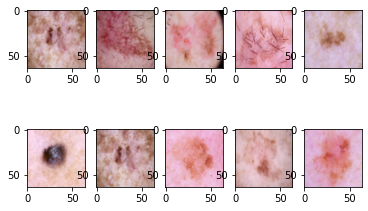

In [39]:
#print some image
index = 1
for image in df_balance['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [40]:
#to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

df_balance['image'] = df_balance['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df_balance['image'].to_list())
data = data/255.0 #scale the value from [0...1]
label = df_balance['label']
label_cat = to_categorical(label,num_classes=7)

train_data,test_data,train_label,test_label = train_test_split(data,label_cat,test_size=0.25,random_state=999)


In [41]:
#setup model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(image_size, image_size, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 256)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 128)       295040    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)       

In [42]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 200
epochs = 20

train_history = model.fit(
    train_data,train_label,
    epochs=epochs,
    batch_size = batch_size,
    validation_split=0.2,
    verbose=2)

Epoch 1/20
9/9 - 16s - loss: 1.8354 - acc: 0.1750 - val_loss: 1.8102 - val_acc: 0.2067
Epoch 2/20
9/9 - 16s - loss: 1.7939 - acc: 0.1894 - val_loss: 1.8029 - val_acc: 0.1800
Epoch 3/20
9/9 - 16s - loss: 1.7658 - acc: 0.2567 - val_loss: 1.7589 - val_acc: 0.2733
Epoch 4/20
9/9 - 16s - loss: 1.7070 - acc: 0.2644 - val_loss: 1.6975 - val_acc: 0.2689
Epoch 5/20
9/9 - 16s - loss: 1.6425 - acc: 0.2956 - val_loss: 1.6625 - val_acc: 0.3422
Epoch 6/20
9/9 - 16s - loss: 1.5704 - acc: 0.3483 - val_loss: 1.5560 - val_acc: 0.3844
Epoch 7/20
9/9 - 16s - loss: 1.4834 - acc: 0.4028 - val_loss: 1.4680 - val_acc: 0.4400
Epoch 8/20
9/9 - 16s - loss: 1.3561 - acc: 0.4461 - val_loss: 1.3476 - val_acc: 0.4756
Epoch 9/20
9/9 - 15s - loss: 1.2649 - acc: 0.4933 - val_loss: 1.2452 - val_acc: 0.4978
Epoch 10/20
9/9 - 15s - loss: 1.2067 - acc: 0.5150 - val_loss: 1.2247 - val_acc: 0.4867
Epoch 11/20
9/9 - 15s - loss: 1.2310 - acc: 0.5078 - val_loss: 1.2910 - val_acc: 0.5200
Epoch 12/20
9/9 - 16s - loss: 1.2144 - ac

In [43]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.show()

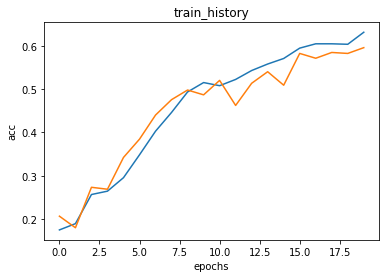

In [44]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

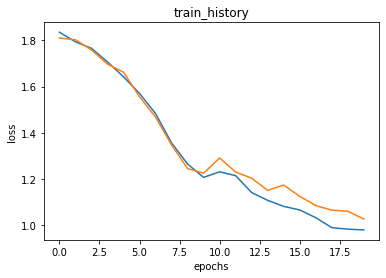

In [45]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [46]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

24/24 [==============================] - 2s 65ms/step - loss: 0.9902 - acc: 0.6213

In [47]:
#predictions

prediction = model.predict(test_data)
prediction_class = np.argmax(prediction,axis=1)
prediction_label = np.argmax(test_label,axis=1)


print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))

predict   0   2   3   4   5    6
label                           
0        34  26  47   7   5    0
2        11  83   5  16  10    2
3        10  21  87   3   3    2
4         2  37   4  66  29    5
5         4  14   4  11  75    2
6         3   0   1   0   0  121
